# PM Sync Motor Temperature Modeling

Pre-processing, Feature engineering, model training and prediction is performed on a dataset available for modeling the temperature of a permanent magnet synchronous motor (PMSM) in real-time. The intricate structure of a traction drive restricts direct measurement of rotor temperatures with thermal sensors. Further, the stator temperatures, sensor outage or quality degradation cannot be administered properly. Therefore, we try to model with appropriate **feature engineering** that estimates the four target temperatures.

## 1 Data Description

**Target features:**
1. stator_yoke
2. stator_winding
3. stator_tooth
4. pm

**Input features:**
The remaining features exclusive torque.

1. u_q: Voltage q-component measurement in dq-coordinates (in Volts)
2. coolant: coolant temperature (in Celsius)
3. stator_winding: temperature (in Celsius)
4. u_d: Voltage d-component measurement in dq-coordinates (in Volts)
5. stator_tooth: stator tooth temperature (in Celsius)
6. motor_speed: (in rpm)
7. i_d: current d-component measurement
8. i_q: current q-component measurement
9. pm: peranent magnet temperature (in Celsius)
10. stator_yoke: Stator yoke temperature (in Celsius)

**Cross-validation**
Profile no. 65 and 72 are for testing purposes.

Each row represents a snapshot of sensor data at a certain time step with a sampling rate of 2 Hz. Every measurement session has a unique `profile_id`.

## 2 Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [50]:
data = pd.read_csv("https://media.githubusercontent.com/media/Massine/Electric_motor_temperature/master/01_Data/01_Raw/pmsm_temperature_data.csv")
data.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


1.  Above columns are result of a standard control strategy trying to follow the reference speed and torque
2. `motor_speed` and `torque` are the resulting quantities achieved by above strategy, derived from set currents and voltages
3. Target features are rotor temperature: `pm`, stator temperature: `stator_*` and `torque`. 

Being able to have strong estimators for the rotor temperature helps the automotive industry to manufacture motors with less material and enables control strategies to utilize the motor to its maximum capability.
A precise torque estimate leads to more accurate and adequate control of the motor, reducing power losses and eventually heat build-up.

Now we further, perform sanity checks on the data.

In [51]:
# check for missing values in the dataset
data.isnull().sum()

ambient           0
coolant           0
u_d               0
u_q               0
motor_speed       0
torque            0
i_d               0
i_q               0
pm                0
stator_yoke       0
stator_tooth      0
stator_winding    0
profile_id        0
dtype: int64

Mentioned in the datasource, data from `profile_id` 65 and 72 are stacked for testing whereas the other profiles are used for training.

In [65]:
data_test = data[(data['profile_id'] == 65) | (data['profile_id'] == 72)]
data = data[(data['profile_id'] != 65) & (data['profile_id'] != 72)]

There are no missing values in the dataset therefore, no need for any imputation strategies.

## 2 Exploratory Data Analysis

*Quantitative Analysis:*
Obtain a 5-point summary

In [66]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ambient,942677.0,-0.030010,1.007729,-8.573954,-0.634542,0.242495,0.681905,2.967117
coolant,942677.0,-0.008238,1.009503,-1.429349,-1.041886,-0.185147,0.698607,2.649032
u_d,942677.0,-0.021835,0.994308,-1.655373,-0.854390,0.225416,0.356361,2.274734
u_q,942677.0,0.007720,0.996054,-1.861463,-0.881885,-0.089520,0.859836,1.793498
motor_speed,942677.0,0.003210,0.996456,-1.371529,-0.951878,-0.140245,0.855827,2.024164
torque,942677.0,0.020170,0.999063,-3.345953,-0.265042,-0.121022,0.561778,3.016971
i_d,942677.0,-0.002465,1.000106,-3.245874,-0.760764,0.196713,1.013952,1.060937
i_q,942677.0,0.019958,0.999683,-3.341639,-0.254672,-0.091449,0.543750,2.914185
pm,942677.0,-0.005093,1.001414,-2.631991,-0.667836,0.099152,0.677849,2.917456
stator_yoke,942677.0,-0.004537,1.004053,-1.834688,-0.747183,-0.056538,0.688808,2.449158


1. There are 942677 observations in the dataset.
2. The mean and median of all the variables are close to each other that indicates low skewness in the dataset.
3. `motor_speed` has the widest range of measurements which indicates we might have to scale the variables before performing any analysis

*Visual Analysis*

<AxesSubplot:>

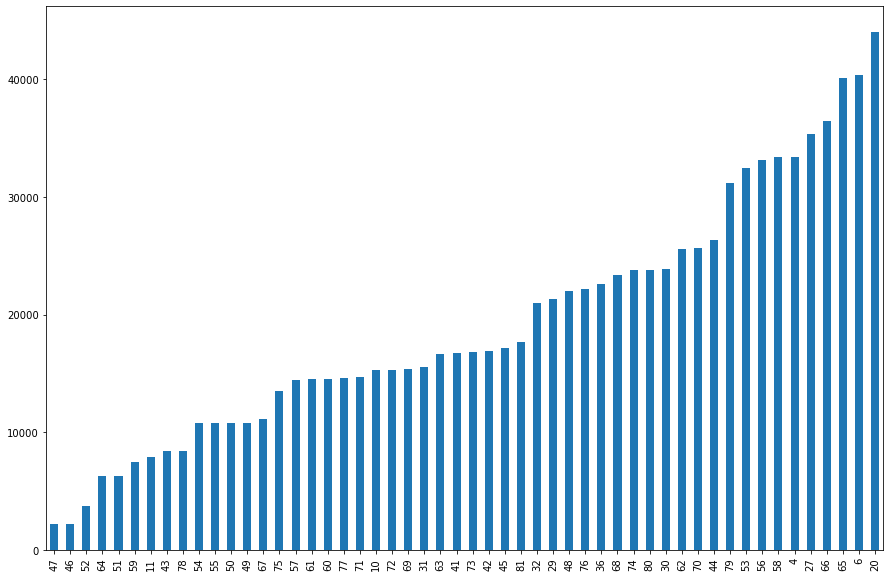

In [53]:
plt.figure(figsize = (15, 10))
data['profile_id'].value_counts().sort_values().plot(kind = 'bar')

Session ids 66, 6 and 20 have the most number of measurement data.
Further, observing the data distribution and presence of outliers can help determining anomalies in the variables.

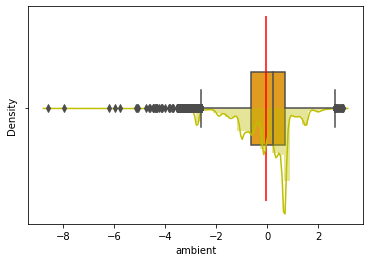

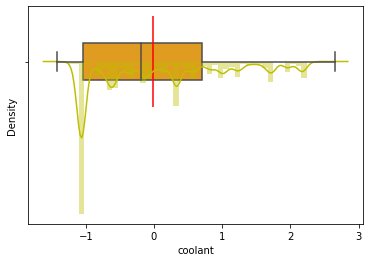

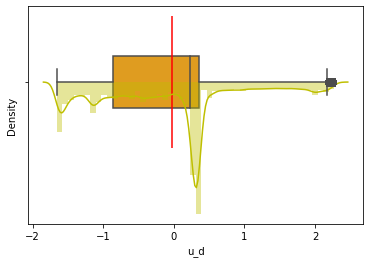

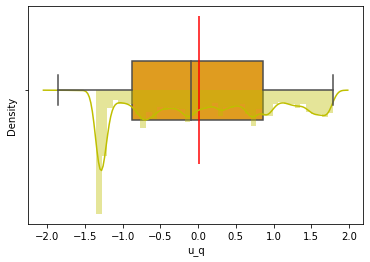

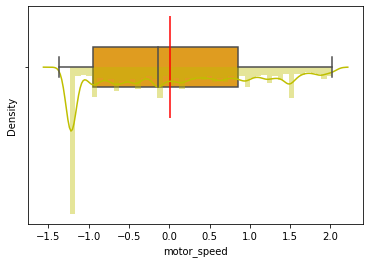

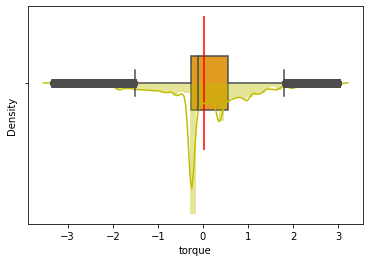

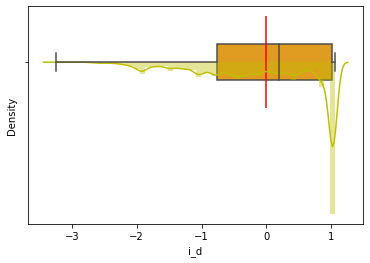

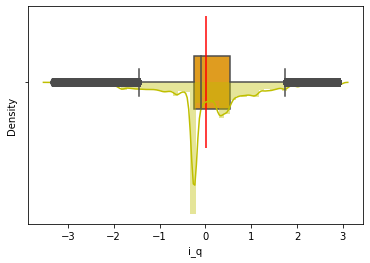

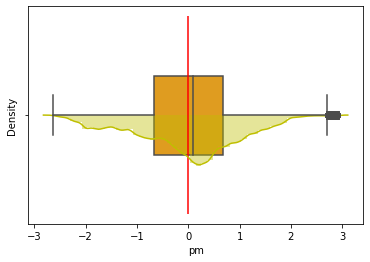

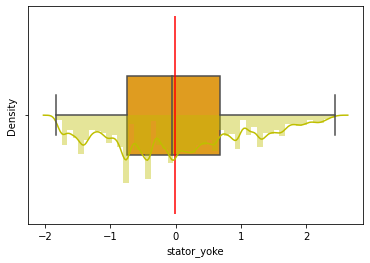

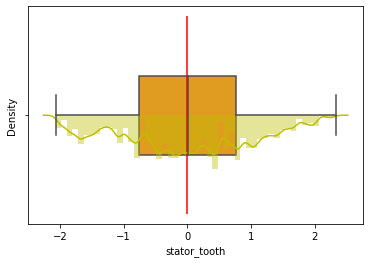

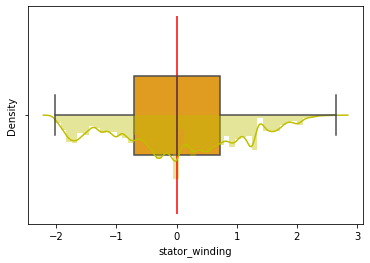

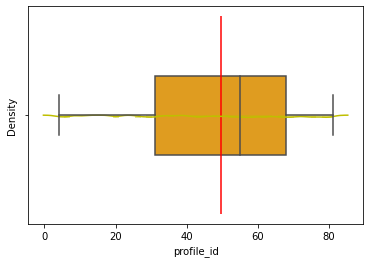

In [68]:
for i in data.columns:
    sns.distplot(data[i], color = 'y', kde = True)
    sns.boxplot(data[i], color = 'orange')
    plt.vlines(data[i].mean(), ymin = -1, ymax = 1, color = 'r')
    plt.show()

The density distribution suggests a low skewed profile for `motor_speed` and `i_d` with following observations:
1. Outliers found in `coolant`, `u_d`, `i_q`, `ambient` and `torque`
2. Skewness confirmed visually as stated in previous steps.

Following is a check for skew and kurtosis (measure of tailedness of the probability distribution of the variables).

In [69]:
import scipy.stats as stats
for i in data.columns:
    print(i, ':\nSkew: ', data[i].skew(), ':\nKurtosis: ', data[i].kurt())
    print()

ambient :
Skew:  -0.8071873478865997 :
Kurtosis:  0.6969970305203854

coolant :
Skew:  0.6405765703677487 :
Kurtosis:  -0.762280458904407

u_d :
Skew:  0.21732958406019895 :
Kurtosis:  -0.5172885804724348

u_q :
Skew:  0.18514589739802864 :
Kurtosis:  -1.2623624326900413

motor_speed :
Skew:  0.3326222639822973 :
Kurtosis:  -1.152694198978819

torque :
Skew:  -0.053666005918621015 :
Kurtosis:  0.777461848244013

i_d :
Skew:  -0.6198973941589144 :
Kurtosis:  -0.7509222702006975

i_q :
Skew:  -0.08850143002199985 :
Kurtosis:  0.7775825670933418

pm :
Skew:  -0.24570361489011244 :
Kurtosis:  -0.33467680472022776

stator_yoke :
Skew:  0.25188191404697025 :
Kurtosis:  -0.7134785655139653

stator_tooth :
Skew:  -0.08028656543420369 :
Kurtosis:  -0.7536349828238866

stator_winding :
Skew:  -0.04548823290271412 :
Kurtosis:  -0.7012550470798771

profile_id :
Skew:  -0.5391816798110003 :
Kurtosis:  -0.7533926942030775



All the variables have a platykurtic distribution with positive or negative skew as indicated by the values.

<AxesSubplot:>

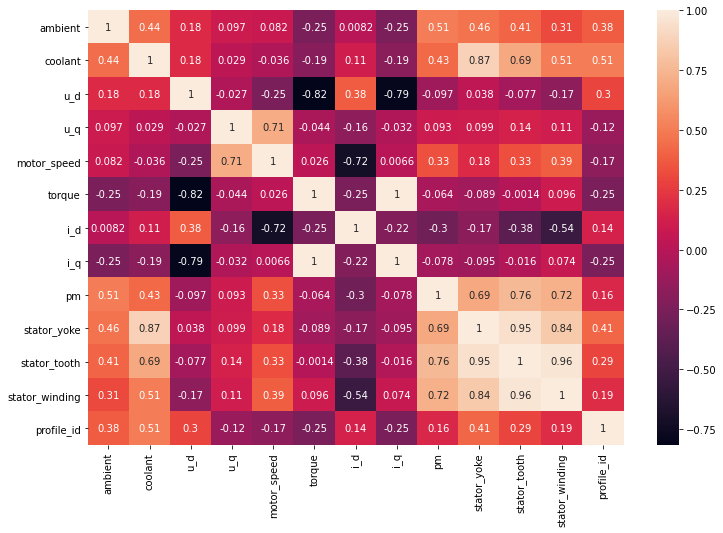

In [70]:
plt.figure(figsize = (12,8))
sns.heatmap(data.corr(), annot = True)

# Following are the observations:
1. `torque` and `i_q` are perfectly correlated
2. High correlation between `stator_winding`, `stator_yoke` and `stator_tooth`. 
3. `coolant` has a positive high linear correlation with `stator_yoke`
4. `torque` and `u_d` are negatively correlated
5. `motor_speed` and `i_d` are negatively correlated

Comparing the temperatures of the 3 stator components for a random measurement number 20, we observe the following:

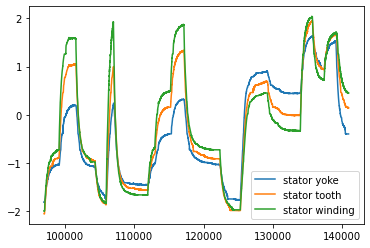

In [71]:
data[data['profile_id'] == 20]['stator_yoke'].plot(label = 'stator yoke')
data[data['profile_id'] == 20]['stator_tooth'].plot(label = 'stator tooth')
data[data['profile_id'] == 20]['stator_winding'].plot(label = 'stator winding')
plt.legend()

The three stator components follow a similar measurement variance. We can infer that the motor has not been allowed to cool down as indicated by the trend noticed in the graph above for `stator yoke` and `stator winding`.

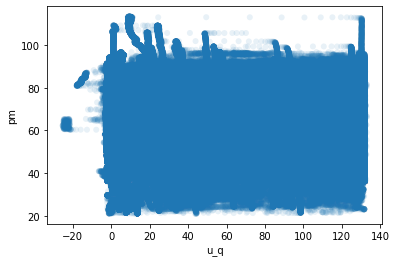

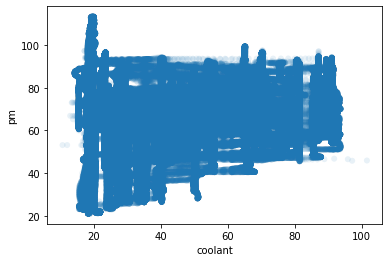

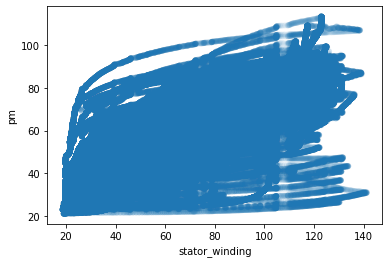

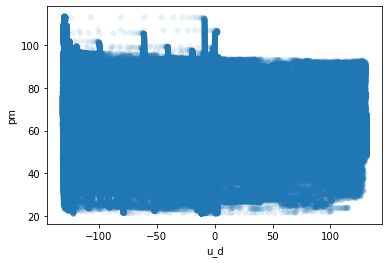

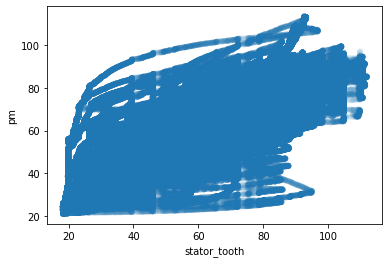

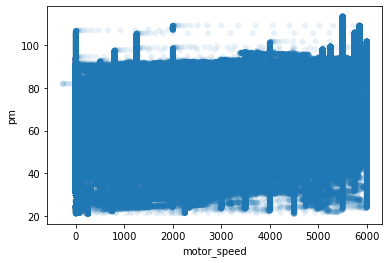

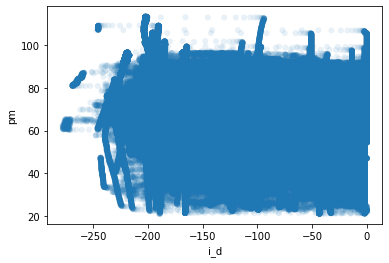

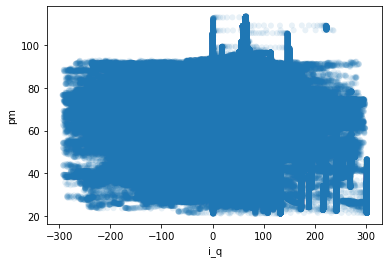

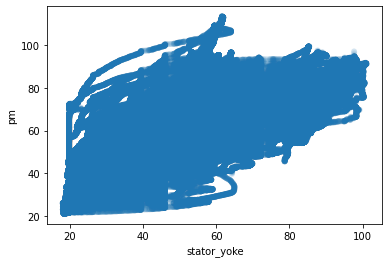

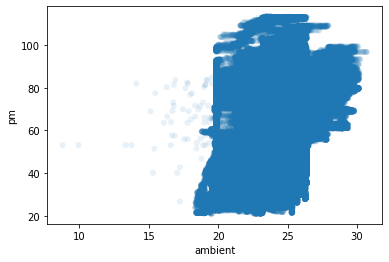

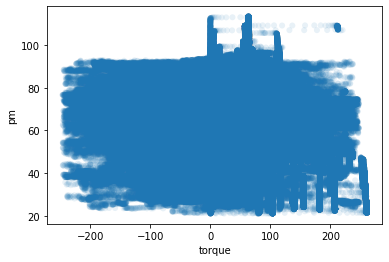

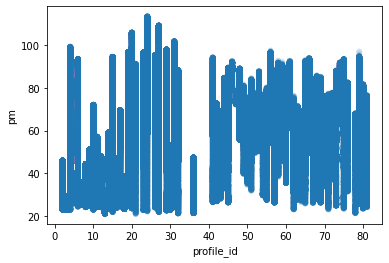

In [11]:
for i in data.columns[data.columns != 'pm']:
    sns.scatterplot(data[i], data['pm'], edgecolor = 'none', alpha = 0.1)
    plt.show()

 We drop `profile_id` since the readings are sorted by time, i.e. arranged in series of time.

In [73]:
data_train.drop('profile_id', axis = 1, inplace = True)
data_test.drop('profile_id', axis = 1, inplace = True)

## 3 Statistical Analysis of Variables

The statistical significance is checked for each variable to identify their contribution to the rotor temperature.

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942677 entries, 0 to 982769
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ambient         942677 non-null  float64
 1   coolant         942677 non-null  float64
 2   u_d             942677 non-null  float64
 3   u_q             942677 non-null  float64
 4   motor_speed     942677 non-null  float64
 5   torque          942677 non-null  float64
 6   i_d             942677 non-null  float64
 7   i_q             942677 non-null  float64
 8   pm              942677 non-null  float64
 9   stator_yoke     942677 non-null  float64
 10  stator_tooth    942677 non-null  float64
 11  stator_winding  942677 non-null  float64
 12  profile_id      942677 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 100.7 MB


In [75]:
from scipy.stats import shapiro
for i in data.columns:
    print('\nShapiro result for ', i, ': \n', shapiro(data[i]))


Shapiro result for  ambient : 
 ShapiroResult(statistic=0.9440718293190002, pvalue=0.0)

Shapiro result for  coolant : 
 ShapiroResult(statistic=0.8946822285652161, pvalue=0.0)

Shapiro result for  u_d : 
 ShapiroResult(statistic=0.9543233513832092, pvalue=0.0)

Shapiro result for  u_q : 
 ShapiroResult(statistic=0.9276503920555115, pvalue=0.0)

Shapiro result for  motor_speed : 
 ShapiroResult(statistic=0.9210241436958313, pvalue=0.0)

Shapiro result for  torque : 
 ShapiroResult(statistic=0.9724035263061523, pvalue=0.0)

Shapiro result for  i_d : 
 ShapiroResult(statistic=0.8836645483970642, pvalue=0.0)

Shapiro result for  i_q : 
 ShapiroResult(statistic=0.9700843691825867, pvalue=0.0)

Shapiro result for  pm : 
 ShapiroResult(statistic=0.9890855550765991, pvalue=0.0)

Shapiro result for  stator_yoke : 
 ShapiroResult(statistic=0.9791814088821411, pvalue=0.0)

Shapiro result for  stator_tooth : 
 ShapiroResult(statistic=0.9836587309837341, pvalue=0.0)

Shapiro result for  stator_wi

If we consider the following:
Null hypothesis: variance of variable is equal to the variance of `pm`
Alternate hypothesis: variance of variable is not equal to the variance of `pm`

Performing a Bartlett's test for equal variances.

In [76]:
hyp_response = []
from scipy.stats import bartlett
for i in data.columns[data.columns != 'pm']:
    hyp_response.append(bartlett(data[i], data['pm']).pvalue > 0.05)
    
print(hyp_response)

[False, False, False, False, False, False, True, True, False, True, False, False]


p-value is greater than 0.05 therefore, we fail to reject the null hypothesis that says the variance of d)

The output from `hyp_response` indicates that none of the variables have a p-value less than 0.05 therefore, we reject the null hypothesis. The variance in any variable is not equal to the variance of rotor temperature.

## 5 Scaling / Train-Test Splitting

The datasets `data_test` and `data_train` are scaled and split into training and testing sets.

The temperatures of stator components and rotor(pm) are response variables that we wish to predict therefore, it will be dropped from the training dataset for regression. Since torque is an improperly measured variable, it is dropped as well. Scale the datasets before modeling...

In [19]:
from sklearn.preprocessing import MinMaxScaler
X_data_train = data_train.drop(['pm', 'stator_yoke', 'stator_tooth', 'stator_winding', 'torque'], axis = 1)
X_data_train.info()
X_data_train = MinMaxScaler().fit_transform(X_data_train)
X_data_train = pd.DataFrame(X_data_train, columns = ['u_q', 'coolant', 'u_d', 'motor_speed', 'i_d', 'i_q', 'ambient'])
y_data_train = data_train['pm']
print('\n\n')
X_data_test = data_test.drop(['pm', 'stator_yoke', 'stator_tooth', 'stator_winding', 'torque'], axis = 1)
X_data_test.info()
X_data_test = MinMaxScaler().fit_transform(X_data_test)
X_data_test = pd.DataFrame(X_data_test, columns = ['u_q', 'coolant', 'u_d', 'motor_speed', 'i_d', 'i_q', 'ambient'])
y_data_test = data_test['pm']

y_data_train.reset_index(drop = True, inplace = True)
y_data_test.reset_index(drop = True, inplace = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1275421 entries, 0 to 1330815
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   u_q          1275421 non-null  float64
 1   coolant      1275421 non-null  float64
 2   u_d          1275421 non-null  float64
 3   motor_speed  1275421 non-null  float64
 4   i_d          1275421 non-null  float64
 5   i_q          1275421 non-null  float64
 6   ambient      1275421 non-null  float64
dtypes: float64(7)
memory usage: 77.8 MB



<class 'pandas.core.frame.DataFrame'>
Int64Index: 55395 entries, 984807 to 1082587
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   u_q          55395 non-null  float64
 1   coolant      55395 non-null  float64
 2   u_d          55395 non-null  float64
 3   motor_speed  55395 non-null  float64
 4   i_d          55395 non-null  float64
 5   i_q          55395 non-null  float

Perform a train test split of 70-30...

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data_train, y_data_train, test_size = 0.3, random_state = 101)

## 4 Modeling

### 4.1 Regression

Train a linear regression model where `pm` regresses on other variables.

In [21]:
import statsmodels.api as sm

# add a column of 1s to the training dataset
X_train_const = sm.add_constant(X_train)
linear_mod = sm.OLS(y_train, X_train_const).fit()
linear_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pm   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                 1.984e+05
Date:                Mon, 28 Jun 2021   Prob (F-statistic):               0.00
Time:                        04:09:00   Log-Likelihood:            -3.4840e+06
No. Observations:              892794   AIC:                         6.968e+06
Df Residuals:                  892786   BIC:                         6.968e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          11.5533      0.239     48.383      0.000      11.085      12.021
u_q           -24.3760      0.104   -235.351      0.000     -24.579     -24.173
coolant        24.7694      0.063    392.540      0.000      24.646      24.893
u_d           -16.7138      0.097   -172.024      0.000     -16.904     -16.523
motor_speed    37.1269      0.149    249.681      0.000      36.835      37.418
i_d            -1.7898      0.130    -13.792      0.000      -2.044      -1.535
i_q           -13.6734      0.155    -88.292      0.000     -13.977     -13.370
ambient        74.1406      0.175    424.290      0.000      73.798      74.483
==============================================================================
Omnibus:                    31831.930   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            54122.659
Skew:                           0.312   Prob(JB):                         0.00
Kurtosis:                       4.033   Cond. No.                         46.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 6 Evaluation

Observations:

1. The p-values for each feature is less than 0.05 which means they're significant in predicting the stator winding temperatures.

2. Jarque-Bera test results in a p-value less than 0.05, therefore we reject the null hypothesis that the residuals are normally distributed.

3. The Durbin watson test also yields close to 2 that concludes a very low autocorrelation in the dataset.

We perform a Rainbow test for the linearity assumption. Though the true relationship could be non-linear in nature, a good fit can be achieved from the subset / "middle" of the data. 

Null hypothesis states that the fit of the model using full sample is the same as using a central subset of the dataset.


In [22]:
from statsmodels.stats.diagnostic import linear_rainbow
linear_rainbow(linear_mod)

(0.9979414857060432, 0.754393963563559)

The p-value for rainbow test is greater than 0.05, so we fail to reject the null hypothesis thus, data follows linearity.

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_train_const.values, \
        i) for i in range(X_train_const.shape[1])]
pd.DataFrame(vif, index = X_train_const.columns)

,0
const,354.597294
u_q,5.151188
coolant,1.417146
u_d,3.332342
motor_speed,12.001428
i_d,5.724255
i_q,3.558342
ambient,1.486432


`motor_speed` has a vif value greater than 10 which indicates the presence of multicollinearity in the model through this variable.

<AxesSubplot:ylabel='Density'>

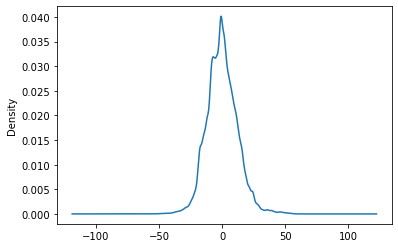

In [24]:
linear_mod.resid.plot(kind = 'density')

Next, we plot a Q-Q plot to test the normality assumption for the residuals.

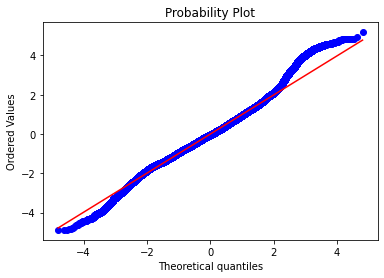

In [25]:
import scipy.stats as stats
import pylab
stud_residual = linear_mod.get_influence().resid_studentized_internal
stats.probplot(stud_residual, dist = "norm", plot = pylab)
plt.show()

The Q-Q and kde plots reveal that the residuals are normally distributed around the centre however, deviate from normal distribution towards the extremes which might be the factor influencing Jarque-Bera test to fail the numerical normality test.

In [26]:
y_train_pred = linear_mod.predict(X_train_const)
train_rmse = np.sqrt(np.mean(((y_train - y_train_pred)**2)))
train_rmse

11.9816275887084

In [27]:
X_test_const = sm.add_constant(X_test)
y_test_pred = linear_mod.predict(X_test_const)
y_test_pred

1259855    68.434964
404375     39.218388
1110343    56.280417
41557      45.253462
577264     55.593669
             ...    
149302     41.313668
650862     69.012319
359881     42.729101
691047     59.467753
1137682    55.524189
Length: 382627, dtype: float64

Calculating the Mean Squared Prediction Error (MSPE)

In [28]:
test_rmse = np.sqrt(np.mean((y_test - y_test_pred)**2))
test_rmse

11.985771289884747

The Adjusted Rsquared value is...

In [29]:
linear_mod.rsquared_adj

0.6086628949604346

## 7 Data processing

### 7.1 Variable Transformation
We make transformations on the variables to improve the normality graph.

In [32]:
X_trans = X_data_train
X_trans['coolant'] = np.power(X_trans['coolant'], 1/3)
X_trans['ambient'] = np.power(X_trans['ambient'], 3)
X_trans['i_d'] = np.power(X_trans['i_d'], 3)

0.30931328658763796


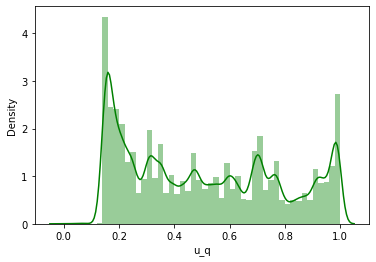

0.6213849393652717


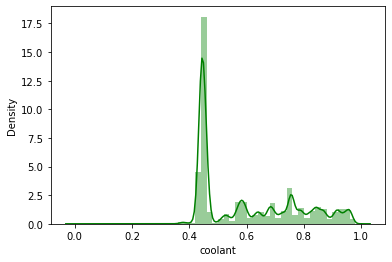

0.15166516262194318


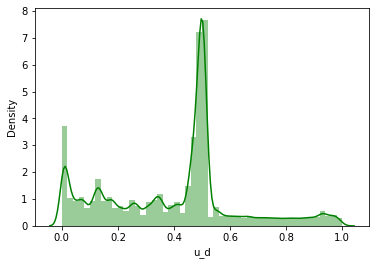

0.3878760414863019


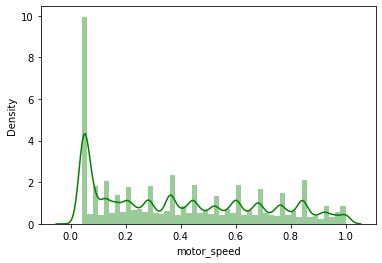

-0.0019146171737054278


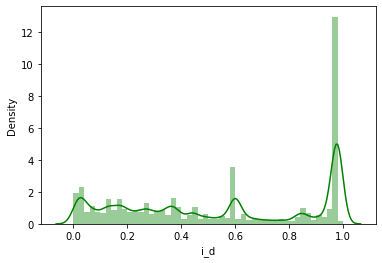

-0.15657699583736054


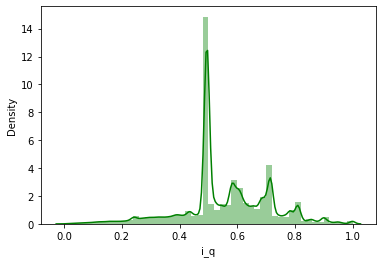

0.3218891714667212


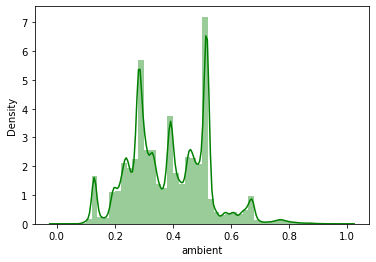

In [33]:
for i  in X_trans.columns:
    print(X_trans[i].skew())
    sns.distplot(X_trans[i], color = 'g')
    plt.show()

Next, we drop the datapoints that are 3 z-scores away from the mean value...

In [34]:
z = np.abs(stats.zscore(X_trans))
X_trans = X_trans.drop(np.where(z > 3)[0][0:])
X_trans.reset_index(drop = True, inplace = True)
y_data_train = y_data_train.drop(np.where(z > 3)[0][0:])
y_data_train.reset_index(drop = True, inplace = True)

In [35]:
print(X_trans.shape)
print(y_data_train.shape)

(1263810, 7)
(1263810,)


In [36]:
X_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263810 entries, 0 to 1263809
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   u_q          1263810 non-null  float64
 1   coolant      1263810 non-null  float64
 2   u_d          1263810 non-null  float64
 3   motor_speed  1263810 non-null  float64
 4   i_d          1263810 non-null  float64
 5   i_q          1263810 non-null  float64
 6   ambient      1263810 non-null  float64
dtypes: float64(7)
memory usage: 67.5 MB


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_trans, y_data_train, test_size = 0.3, random_state = 101)

In [38]:
X_train_const = sm.add_constant(X_train)
linear_mod = sm.OLS(y_train, X_train_const).fit()
linear_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pm   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                 1.946e+05
Date:                Mon, 28 Jun 2021   Prob (F-statistic):               0.00
Time:                        04:17:54   Log-Likelihood:            -3.4547e+06
No. Observations:              884667   AIC:                         6.909e+06
Df Residuals:                  884659   BIC:                         6.909e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          28.6377      0.197    145.646      0.000      28.252      29.023
u_q           -25.9768      0.084   -308.115      0.000     -26.142     -25.812
coolant        34.4376      0.091    376.458      0.000      34.258      34.617
u_d           -16.4660      0.105   -157.247      0.000     -16.671     -16.261
motor_speed    40.7043      0.135    300.792      0.000      40.439      40.969
i_d             1.5419      0.077     19.941      0.000       1.390       1.693
i_q           -11.4278      0.176    -64.993      0.000     -11.772     -11.083
ambient        47.0410      0.123    382.001      0.000      46.800      47.282
==============================================================================
Omnibus:                    35593.532   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            65922.232
Skew:                           0.319   Prob(JB):                         0.00
Kurtosis:                       4.175   Cond. No.                         39.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
y_train_pred = linear_mod.predict(X_train_const)
train_rmse = np.sqrt(np.mean((y_train - y_train_pred)**2))
train_rmse

12.014343966481924

In [41]:
X_test_const = sm.add_constant(X_test)
y_test_pred = linear_mod.predict(X_test_const)
test_rmse = np.sqrt(np.mean((y_test - y_test_pred)**2))
test_rmse

12.003873132929874

The transformation on the variables `coolant`, `ambient` and `i_d` is discarded since there is no improvement in the rmse post transformation on data.

Further, we deal with the multicollinearity observed in the `coolant` variable using Principal Component Analysis (PCA).

### 7.2 PCA

In [42]:
X_train_data = X_trans
from sklearn.decomposition import PCA
pca = PCA().fit(X_train_data)
pca.explained_variance_ratio_
np.cumsum(pca.explained_variance_ratio_)

array([0.51852004, 0.74188252, 0.85829998, 0.93510528, 0.97225486,
       0.99309045, 1.        ])

97.22% of the variance in data is explained by the first 5 principal components. Thus, we will choose the 5 components and observe for any improvement in the linear regression model.

In [43]:
X_pca = PCA(n_components = 5).fit_transform(X_train_data)
X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_pca, y_data_train, test_size = 0.3, random_state = 101)
X_pca_train_const = sm.add_constant(X_pca_train)
linear_mod = sm.OLS(y_train, X_pca_train_const).fit()
linear_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pm   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                 2.590e+05
Date:                Mon, 28 Jun 2021   Prob (F-statistic):               0.00
Time:                        05:40:55   Log-Likelihood:            -3.4681e+06
No. Observations:              884667   AIC:                         6.936e+06
Df Residuals:                  884661   BIC:                         6.936e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.1808      0.013   4486.141      0.000      58.155      58.206
x1            17.5884      0.028    630.767      0.000      17.534      17.643
x2            -3.9685      0.042    -93.378      0.000      -4.052      -3.885
x3            30.7294      0.059    522.222      0.000      30.614      30.845
x4           -48.7771      0.073   -672.577      0.000     -48.919     -48.635
x5           -42.0635      0.104   -403.703      0.000     -42.268     -41.859
==============================================================================
Omnibus:                    37596.472   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            72635.569
Skew:                           0.322   Prob(JB):                         0.00
Kurtosis:                       4.247   Cond. No.                         8.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
y_train_pred = linear_mod.predict(X_pca_train_const)
train_rmse = np.sqrt(np.mean((y_train - y_train_pred)**2))
train_rmse

12.198160725117525

In [47]:
X_pca_test_const = sm.add_constant(X_pca_test)
y_test_pred = linear_mod.predict(X_pca_test_const)
test_rmse = np.sqrt(np.mean((y_test - y_test_pred)**2))
test_rmse

12.192862415725168

There is no significant improvement in the rmse therefore we will not continue with PCA transformation.

We will drop `i_d` and `i_q` based on the statistical analysis